# Quantitative sensitivity analysis



Here we show how to compute generalized Sobol indices on the **EOQ** model using the algorithm presented in Kucherenko et al. 2012. We import our model function from ``temfpy`` and use the Kucherenko indices function from ``econsa``. 

In [24]:
import matplotlib.pyplot as plt
import numpy as np

from temfpy.uncertainty_quantification import eoq_model
from econsa.kucherenko import kucherenko_indices

The function ``kucherenko_indices`` expects the input function to be broadcastable over rows, that is, a row represents the input arguments for one evaluation. For sampling around the mean parameters we specify a diagonal covariance matrix, where the variances depend on the scaling of the mean. Since the variances of the parameters are unknown prior to our analysis we choose values such that the probability of sampling negative values is negligible. We do this since the **EOQ** model is not defined for negative parameters and the normal sampling does not naturally account for bounds.

In [3]:
def eoq_model_transposed(x):
    """EOQ Model but with variables stored in columns."""
    return eoq_model(x.T)


mean = np.array([1230, 0.0135, 2.15])
cov = np.diag([1, 0.000001, 0.01])

indices = kucherenko_indices(
    func=eoq_model_transposed,
    sampling_mean=mean,
    sampling_cov=cov,
    n_draws=1_000_000,
    sampling_scheme="sobol",
)

Now we are ready to inspect the results.

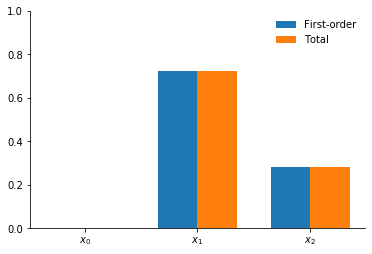

In [26]:
sobol_first = indices.loc[(slice(None), "first_order"), "value"].values
sobol_total = indices.loc[(slice(None), "total"), "value"].values

x = np.arange(3)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, sobol_first, width, label="First-order")
rects2 = ax.bar(x + width / 2, sobol_total, width, label="Total")

ax.set_ylim([0, 1])
ax.legend()

ax.set_xticks(x)
ax.set_xticklabels(["$x_0$", "$x_1$", "$x_2$"])
ax.legend();

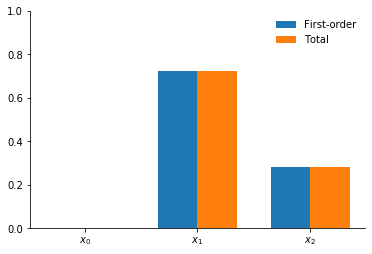

In [27]:
fig